In [8]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig
from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, xcit_small
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, generate_prediction_example
from dl_utils.analysis.confusion_matrix import plot_cm, show_multiple_cm
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.packed_functions import viz_4confusion_matrix, generate_attention_maps
set_style("printing")

symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
bs = 64
num_workers = 1

# imagenet
imagenet_ds = hdf5_dataset('../../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', folder='imagenet', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../../datasets/atom_v5_rot_1m_fix_vector.h5', folder='atom', transform=transforms.ToTensor(), classes=symmetry_classes)
atom_dl = DataLoader(atom_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

# noise
noise_ds = hdf5_dataset('../../../datasets/noise_v5_rot_1m_fix_vector.h5', folder='noise', transform=transforms.ToTensor(), classes=symmetry_classes)
noise_dl = DataLoader(noise_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
# viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn


## Most Confused

#### ResNet50

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


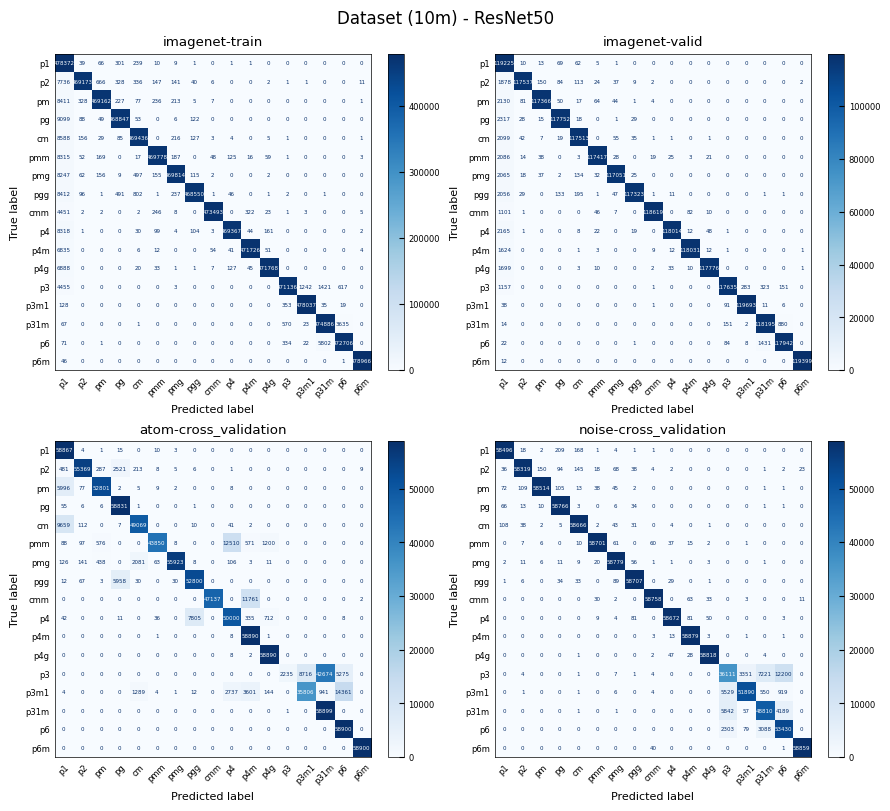

imagenet-train:
Top confused class pairs: 
1. pg → p1 (9099); 2. cm → p1 (8588); 3. pgg → p1 (8412); 4. pm → p1 (8411); 5. p4 → p1 (8318); 6. pmm → p1 (8315); 7. pmg → p1 (8247); 8. p2 → p1 (7736); 9. p4g → p1 (6888); 10. p4m → p1 (6835); 
imagenet-valid:
Top confused class pairs: 
1. pg → p1 (2317); 2. p4 → p1 (2165); 3. pm → p1 (2130); 4. cm → p1 (2099); 5. pmm → p1 (2086); 6. pmg → p1 (2065); 7. pgg → p1 (2056); 8. p2 → p1 (1878); 9. p4g → p1 (1699); 10. p4m → p1 (1624); 
noise-cv:
Top confused class pairs: 
1. p3 → p31m (42674); 2. p3m1 → p6 (14361); 3. pmm → p4 (12510); 4. cmm → p4m (11761); 5. cm → p1 (9659); 6. p3 → p3m1 (8716); 7. p4 → pgg (7805); 8. pm → p1 (5996); 9. pgg → pg (5958); 10. p3 → p6 (5275); 
atom-cv:
Top confused class pairs: 
1. p3 → p6 (12200); 2. p3 → p31m (7221); 3. p31m → p3 (5842); 4. p3m1 → p3 (5529); 5. p31m → p6 (4189); 6. p3 → p3m1 (3351); 7. p6 → p31m (3088); 8. p6 → p3 (2303); 9. p3m1 → p6 (919); 10. p3m1 → p31m (550); 


In [2]:
cm_files = glob.glob(f'../../results/ResNet50/09112024-resnet50-dataset_v5_size-10m-*_cm.npy')
cm_list = viz_4confusion_matrix(cm_files=cm_files, title=f'Dataset (10m) - ResNet50', symmetry_classes=symmetry_classes)

for cm, ds_name in zip(cm_list, ['imagenet-train', 'imagenet-valid', 'noise-cv', 'atom-cv']):
    print(f'{ds_name}:')
    confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

In [4]:
device = torch.device('cuda:6')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']

In [3]:
# skip train_ds as it takes too long

# cm, ds_name = cm_list[0], 'imagenet-train'
# print(f'{ds_name}:')
# confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

# for confusion_pair in confused_list[:2]:
#     for i in range(3):
#         plot_attention_map(model, train_dl, copnfusion_pair=confusion_pair[:2], layers=layers, task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example_{i}')

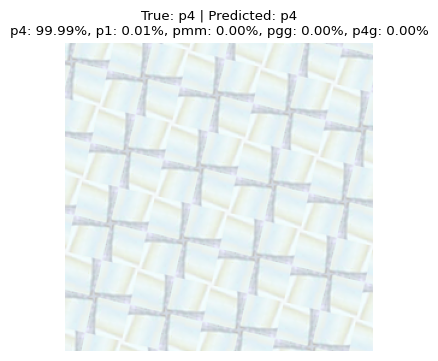

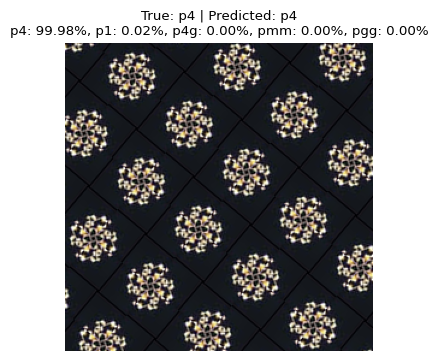

In [14]:
confusion_pair = ('p4', 'p4')
image, label, top_predictions, probs, metadata = generate_prediction_example(model, '../../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', t=confusion_pair[0], p=confusion_pair[1], classes=symmetry_classes, device=device, group='imagenet', viz=True)
image, label, top_predictions, probs, metadata = generate_prediction_example(model, train_dl, t=confusion_pair[0], p=confusion_pair[1], classes=symmetry_classes, device=device, viz=True)

In [ ]:
cm, ds_name = cm_list[1], 'imagenet-valid'
print(f'{ds_name}:')
confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

for confusion_pair in confused_list[:2]:
    image, label, top_predictions, probs = generate_prediction_example(model, '../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', t=confusion_pair[0], p=confusion_pair[1], classes=symmetry_classes, device=device, group='imagenet', viz=True)
    #
    # generate_attention_maps(model, None, valid_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='ResNet50', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')
    generate_attention_maps(model, valid_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='ResNet50', task_name=ds_name, device=device)

NameError: name 'confused_list' is not defined

In [3]:
cm, ds_name = cm_list[2], 'noise-cv'
print(f'{ds_name}:')
confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

for confusion_pair in confused_list[:2]:
    plot_attention_map(model, noise_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='ResNet50', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')


NameError: name 'cm_list' is not defined

In [13]:
cm, ds_name = cm_list[3], 'atom-cv'
print(f'{ds_name}:')
confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

for confusion_pair in confused_list[:2]:
    input_image_np, attention_map_resized = plot_attention_map(model, atom_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='ResNet50', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')

atom-cv:
Top confused class pairs: 
1. p3m1 → p3 (1253); 2. p3 → p6 (1153); 3. p3 → p31m (755); 4. p31m → p3 (602); 5. p31m → p6 (368); 6. p3 → p3m1 (364); 7. p6 → p31m (292); 8. p6 → p3 (237); 9. p3m1 → p6 (165); 10. p3m1 → p31m (72); 


ValueError: Batch limit of None reached without finding misclassified samples.

#### FPN

/home/yichen/Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/m3learning-util/src/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


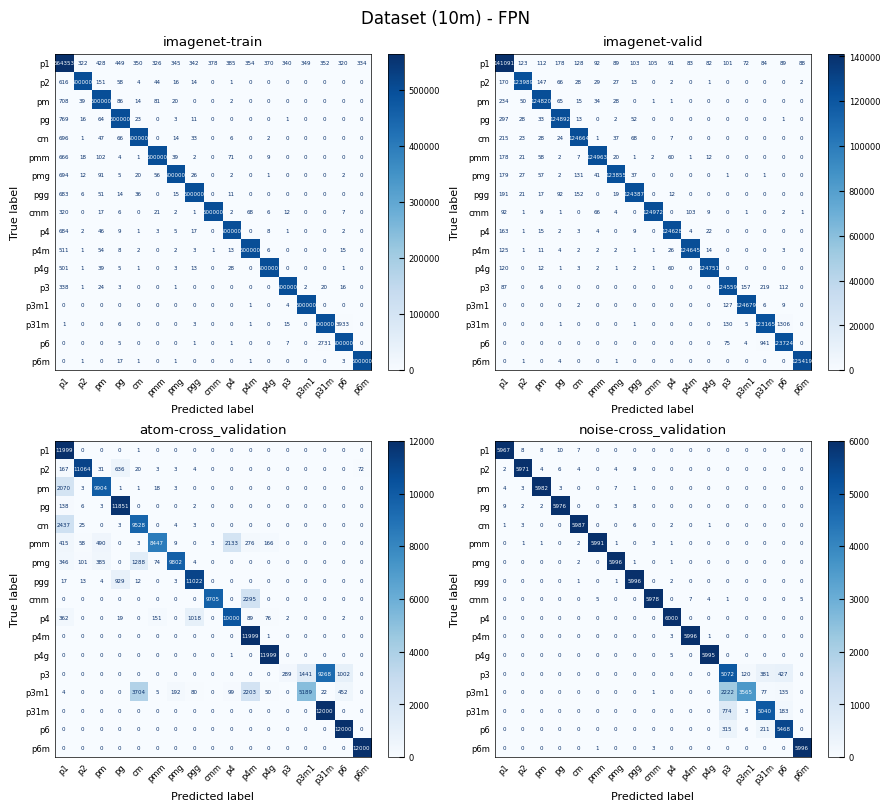

imagenet-train:
Top confused class pairs: 
1. p31m → p6 (3933); 2. p6 → p31m (2731); 3. pg → p1 (769); 4. pm → p1 (708); 5. cm → p1 (696); 6. pmg → p1 (694); 7. p4 → p1 (684); 8. pgg → p1 (683); 9. pmm → p1 (666); 10. p2 → p1 (616); 
imagenet-valid:
Top confused class pairs: 
1. p31m → p6 (1306); 2. p6 → p31m (941); 3. pg → p1 (297); 4. pm → p1 (234); 5. p3 → p31m (219); 6. cm → p1 (215); 7. pgg → p1 (191); 8. pmg → p1 (179); 9. pmm → p1 (178); 10. p1 → pg (178); 
noise-cv:
Top confused class pairs: 
1. p3 → p31m (9268); 2. p3m1 → cm (3704); 3. cm → p1 (2437); 4. cmm → p4m (2295); 5. p3m1 → p4m (2203); 6. pmm → p4 (2133); 7. pm → p1 (2070); 8. p3 → p3m1 (1441); 9. pmg → cm (1288); 10. p4 → pgg (1018); 
atom-cv:
Top confused class pairs: 
1. p3m1 → p3 (2222); 2. p31m → p3 (774); 3. p3 → p6 (427); 4. p3 → p31m (381); 5. p6 → p3 (315); 6. p6 → p31m (211); 7. p31m → p6 (183); 8. p3m1 → p6 (135); 9. p3 → p3m1 (120); 10. p3m1 → p31m (77); 


In [3]:
cm_files = glob.glob(f'../../results/confusion_matrix/FPN/09282024-FPN-dataset_v5_size-10m-*_cm.npy')
cm_list = viz_4confusion_matrix(cm_files=cm_files, title=f'Dataset (10m) - FPN', symmetry_classes=symmetry_classes)
for cm, ds_name in zip(cm_list, ['imagenet-train', 'imagenet-valid', 'noise-cv', 'atom-cv']):
    print(f'{ds_name}:')
    confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

#### XCiT

/home/yichen/Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/m3learning-util/src/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


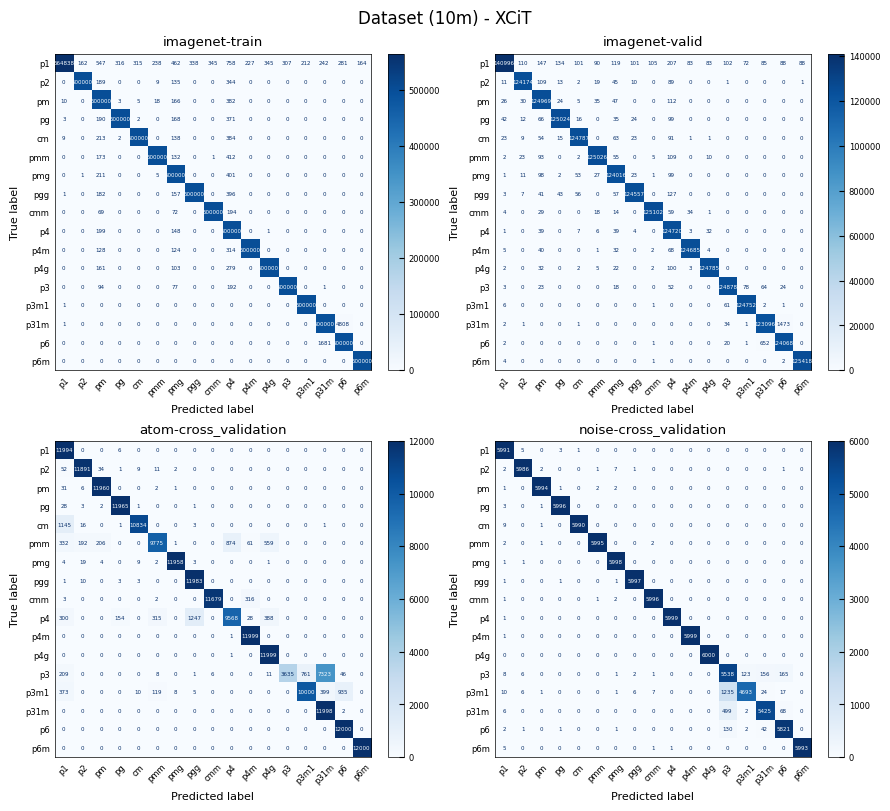

imagenet-train:
Top confused class pairs: 
1. p31m → p6 (4808); 2. p6 → p31m (1681); 3. p1 → p4 (758); 4. p1 → pm (547); 5. p1 → pmg (462); 6. pmm → p4 (412); 7. pmg → p4 (401); 8. pgg → p4 (396); 9. cm → p4 (384); 10. pm → p4 (382); 
imagenet-valid:
Top confused class pairs: 
1. p31m → p6 (1473); 2. p6 → p31m (652); 3. p1 → p4 (207); 4. p1 → pm (147); 5. p1 → pg (134); 6. pgg → p4 (127); 7. p1 → pmg (119); 8. pm → p4 (112); 9. p1 → p2 (110); 10. p2 → pm (109); 
noise-cv:
Top confused class pairs: 
1. p3 → p31m (7323); 2. p4 → pgg (1247); 3. cm → p1 (1145); 4. p3m1 → p6 (935); 5. pmm → p4 (874); 6. p3 → p3m1 (761); 7. pmm → p4g (559); 8. p3m1 → p31m (399); 9. p4 → p4g (388); 10. p3m1 → p1 (373); 
atom-cv:
Top confused class pairs: 
1. p3m1 → p3 (1235); 2. p31m → p3 (499); 3. p3 → p6 (165); 4. p3 → p31m (156); 5. p6 → p3 (130); 6. p3 → p3m1 (123); 7. p31m → p6 (68); 8. p6 → p31m (42); 9. p3m1 → p31m (24); 10. p3m1 → p6 (17); 


In [ ]:
cm_files = glob.glob(f'../../results/confusion_matrix/XCiT/09302024-XCiT-dataset_v5_size-10m-*_cm.npy')
cm_list = viz_4confusion_matrix(cm_files=cm_files, title=f'Dataset (10m) - XCiT', symmetry_classes=symmetry_classes)
for cm, ds_name in zip(cm_list, ['imagenet-train', 'imagenet-valid', 'noise-cv', 'atom-cv']):
    print(f'{ds_name}:')
    confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

In [ ]:
device = torch.device('cuda:9')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = [11, 9, 6, 3, 0]

In [ ]:
# cm, ds_name = cm_list[0], 'imagenet-train'
# print(f'{ds_name}:')
# confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

# for confusion_pair in confused_list[:2]:
#     plot_attention_map(model, train_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='XCiT', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')

imagenet-train:
Top confused class pairs: 
1. p6 → p31m (5096); 2. p31m → p6 (2608); 3. pg → p1 (940); 4. pm → p1 (855); 5. cm → p1 (819); 6. pmg → p1 (770); 7. pgg → p1 (745); 8. p4 → p1 (738); 9. pmm → p1 (729); 10. p2 → p1 (678); 


In [ ]:
cm, ds_name = cm_list[1], 'imagenet-valid'
print(f'{ds_name}:')
confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

for confusion_pair in confused_list[:2]:
    plot_attention_map(model, valid_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='XCiT', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')


In [ ]:
cm, ds_name = cm_list[2], 'noise-cv'
print(f'{ds_name}:')
confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

for confusion_pair in confused_list[:2]:
    plot_attention_map(model, noise_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='XCiT', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')

In [ ]:
cm, ds_name = cm_list[3], 'atom-cv'
print(f'{ds_name}:')
confused_list = most_confused_pairs(cm, symmetry_classes, top_n=10)

for confusion_pair in confused_list[:2]:
    plot_attention_map(model, atom_dl, copnfusion_pair=confusion_pair[:2], layers=layers, model_type='XCiT', task_name=ds_name, device=device, filename=f'../../figures/AttentionMap/{ds_name}-example')

## function test

### ResNet50

In [3]:
device = torch.device('cpu')
model = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Step 1: Run prediction_vs_actual() to check misclassified examples
# prediction_vs_actual(model, atom_ds, valid_dl, device, num_images=6)

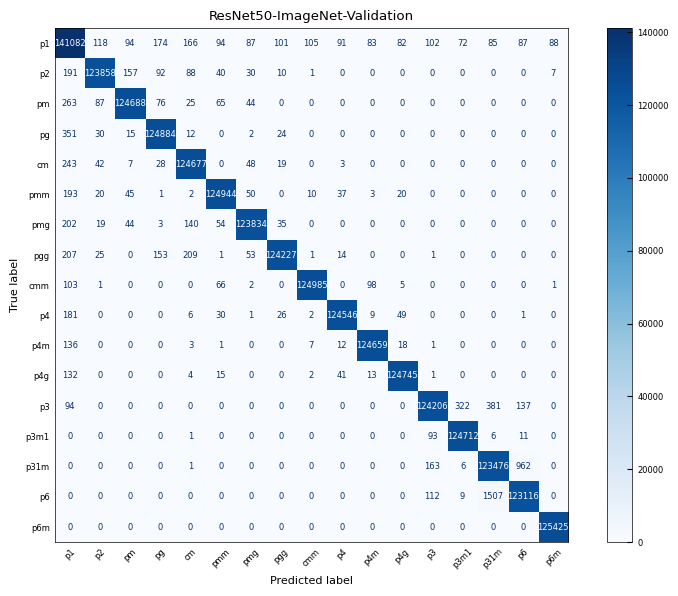

In [4]:
cm = np.load(f'../../results/confusion_matrix/ResNet50/09112024-resnet50-dataset_v5_size-10m-imagenet_valid_cm.npy')
plot_cm(cm=cm, classes=symmetry_classes, title='ResNet50-ImageNet-Validation', show=True, font_size=6)

In [7]:
confused_list = most_confused_pairs(cm, valid_ds, top_n=5)

Top confused class pairs:
p6 ↔ p31m (Misclassified 1507 times)
p31m ↔ p6 (Misclassified 962 times)
p3 ↔ p31m (Misclassified 381 times)
pg ↔ p1 (Misclassified 351 times)
p3 ↔ p3m1 (Misclassified 322 times)


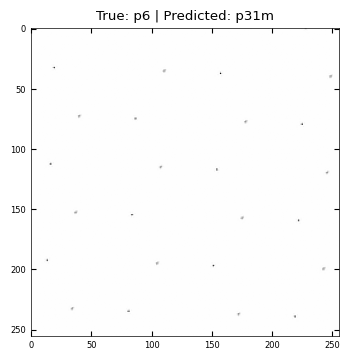

Top 5 incorrect predictions:
p31m: 50.41%
p6: 49.54%
p1: 0.03%
p3: 0.01%
pm: 0.00%


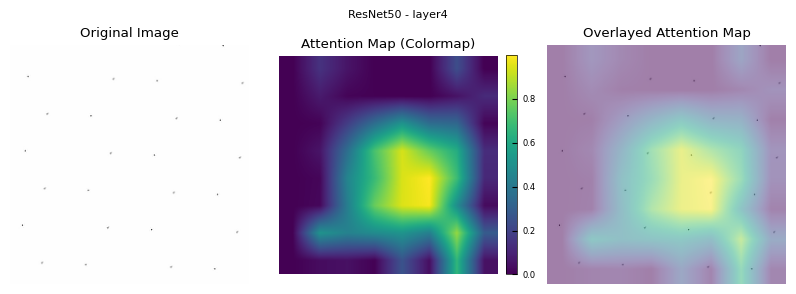

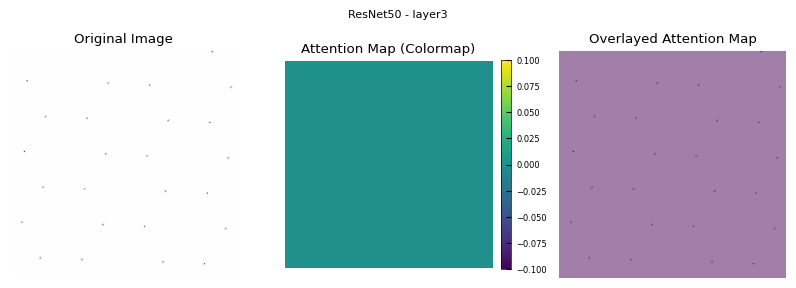

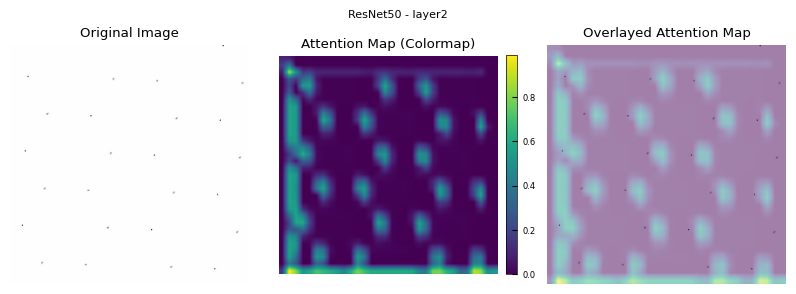

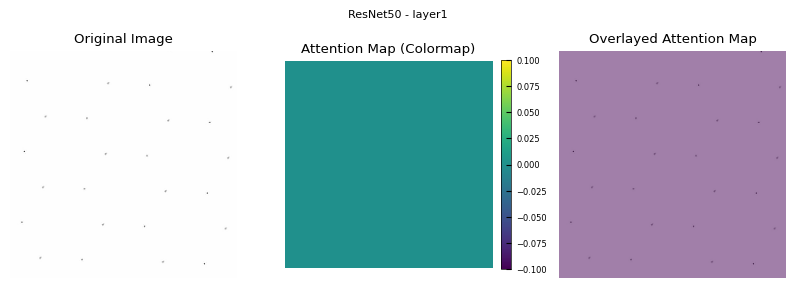

In [12]:
image, probs, classes = show_prediction_example(model, valid_dl, confused_list[0][0], confused_list[0][1], valid_ds.classes, device, k=5)

visualizer = AttentionMapVisualizer()
input_tensor = torch.tensor(image).unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in ['layer4', 'layer3', 'layer2', 'layer1']:
    input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"ResNet50 - {i}")

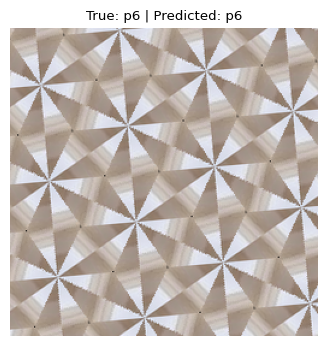

Top 5 incorrect predictions: p6: 99.99%, p1: 0.01%, p31m: 0.00%, p3: 0.00%, pm: 0.00%


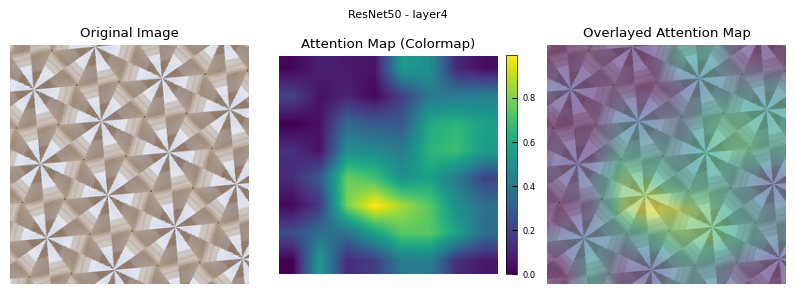

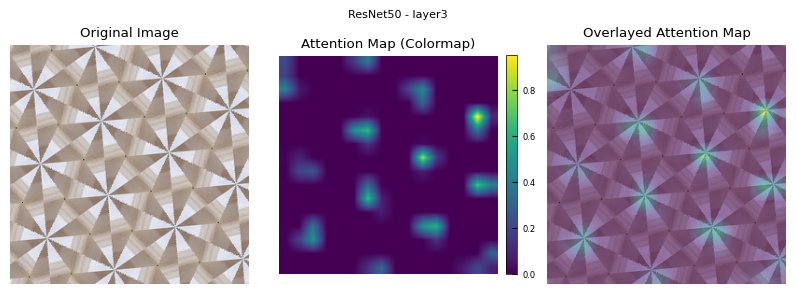

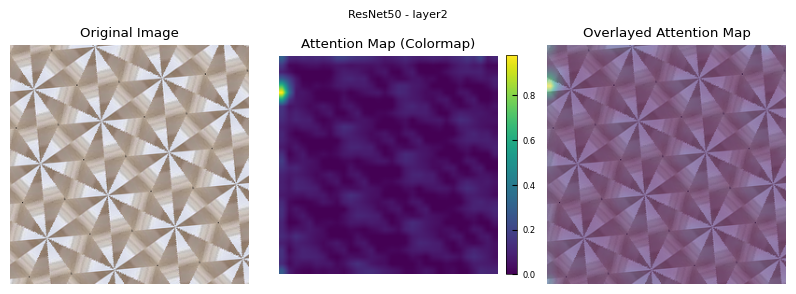

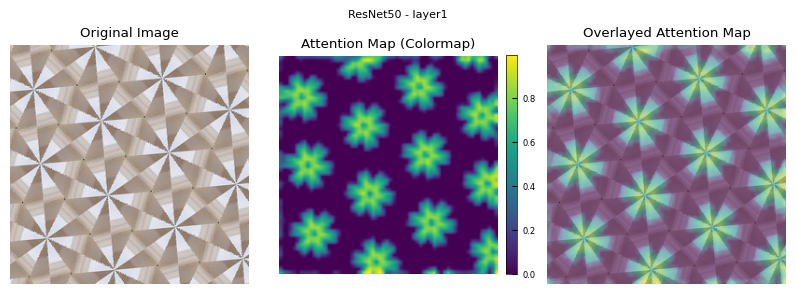

In [14]:
image, probs, classes = show_prediction_example(model, valid_dl, 'p6', 'p6', valid_ds.classes, device, k=5)

visualizer = AttentionMapVisualizer()
input_tensor = torch.tensor(image).unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in ['layer4', 'layer3', 'layer2', 'layer1']:
    input_image_np, attention_map_resized = visualizer.generate_cnn_attention_map(model, input_tensor, layer_name=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"ResNet50 - {i}")

### XCiT

In [3]:
device = torch.device('cpu')
model = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
model.load_state_dict(torch.load('../../models/XCiT/09302024-XCiT-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (pos_embed): PositionalEncodingFourier(
    (token_projection): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x 

In [ ]:
# Step 1: Run prediction_vs_actual() to check misclassified examples
# prediction_vs_actual(model, atom_ds, valid_dl, device, num_images=6)

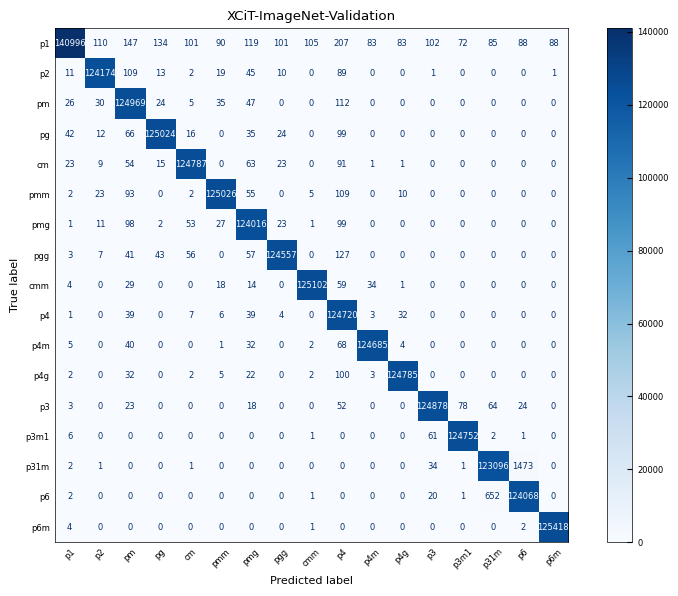

In [4]:
cm = np.load(f'../../results/confusion_matrix/XCiT/09302024-XCiT-dataset_v5_size-10m-imagenet_valid_cm.npy')
plot_cm(cm=cm, classes=symmetry_classes, title='XCiT-ImageNet-Validation', show=True, font_size=6)

In [5]:
confused_list = most_confused_pairs(cm, valid_ds, top_n=5)

Top confused class pairs:
p31m ↔ p6 (Misclassified 1473 times)
p6 ↔ p31m (Misclassified 652 times)
p1 ↔ p4 (Misclassified 207 times)
p1 ↔ pm (Misclassified 147 times)
p1 ↔ pg (Misclassified 134 times)


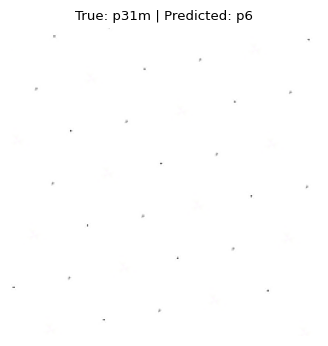

Top 5 incorrect predictions: p6: 99.63%, p31m: 0.37%, p1: 0.01%, p3: 0.00%, pmm: 0.00%


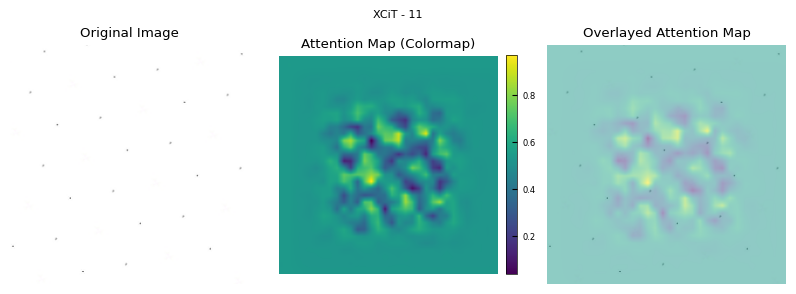

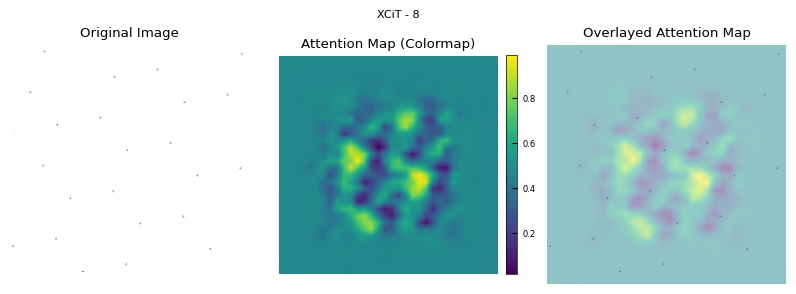

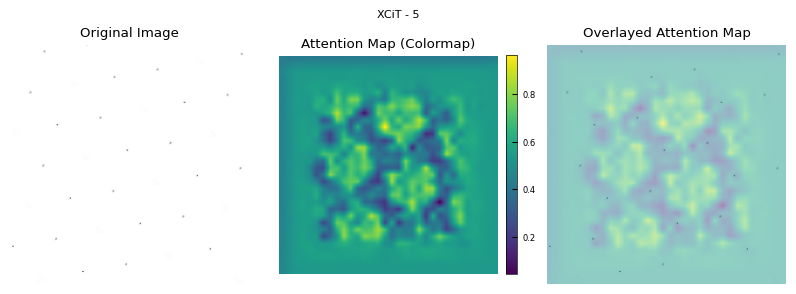

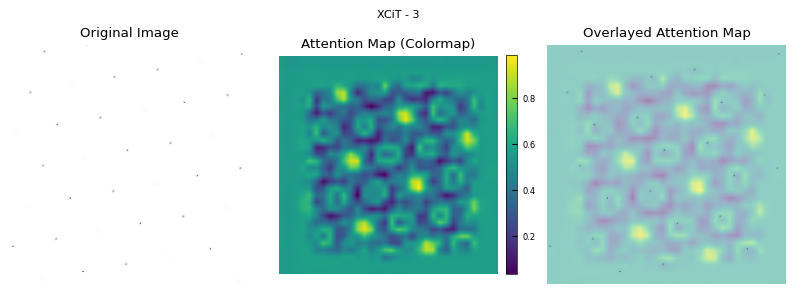

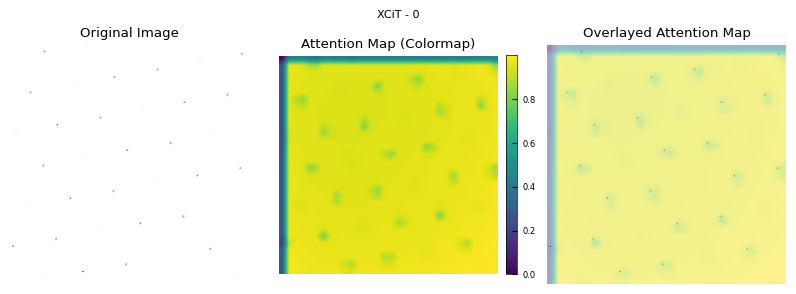

In [6]:
image, probs, classes = show_prediction_example(model, valid_dl, confused_list[0][0], confused_list[0][1], valid_ds.classes, device, k=5)

visualizer = AttentionMapVisualizer()
input_tensor = torch.tensor(image).unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in [11, 8, 5, 3, 0]:
    input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"XCiT - {i}")

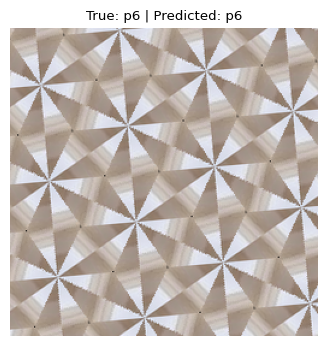

Top 5 incorrect predictions: p6: 99.98%, p1: 0.02%, p4: 0.00%, p6m: 0.00%, pg: 0.00%


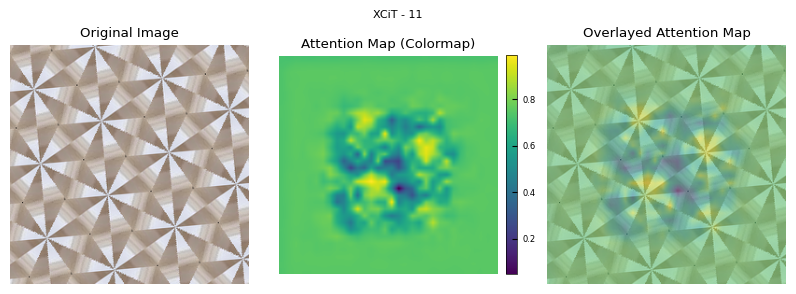

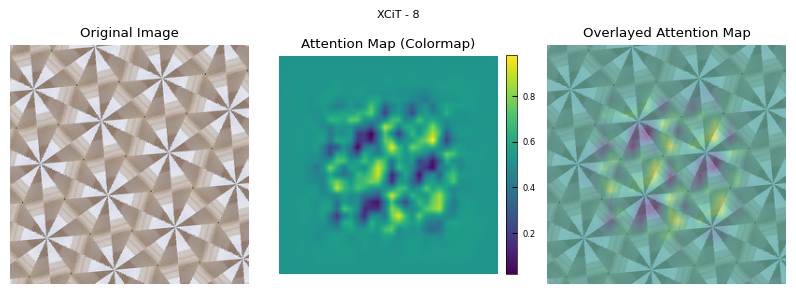

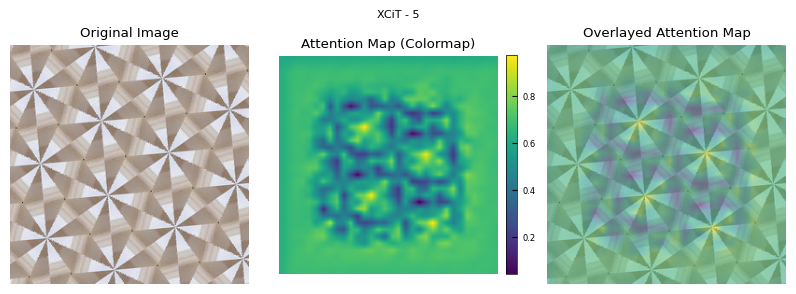

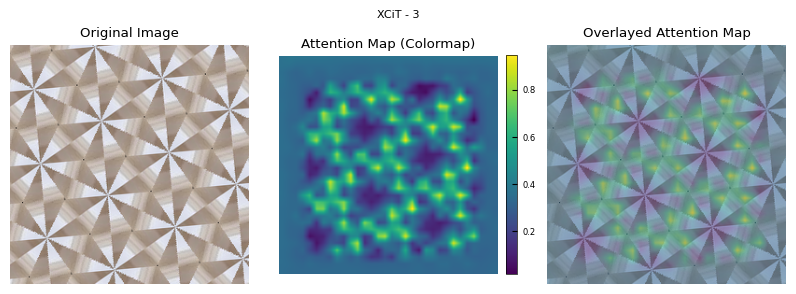

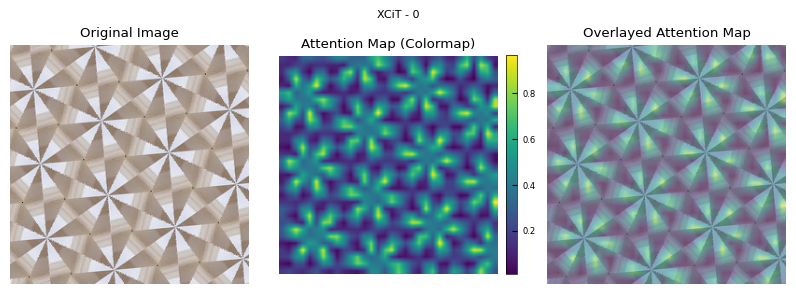

In [7]:
image, probs, classes = show_prediction_example(model, valid_dl, 'p6', 'p6', valid_ds.classes, device, k=5)

visualizer = AttentionMapVisualizer()
input_tensor = torch.tensor(image).unsqueeze(0)  # Example input tensor (N, C, H, W)
for i in [11, 8, 5, 3, 0]:
    input_image_np, attention_map_resized = visualizer.generate_transformer_attention_map(model, input_tensor, attention_layer_idx=i)
    visualizer.visualize_attention_map(input_image_np, attention_map_resized, title=f"XCiT - {i}")

In [ ]:
cm = np.load(f'../../results/confusion_matrix/ResNet50/09112024-resnet50-dataset_v5_size-10m-atom_cross_validation_cm.npy')
# plot_cm(cm=cm, classes=symmetry_classes, title='ResNet50-Atom-Validation', show=True, font_size=6)

Most confused class pair: p3 ↔ p31m


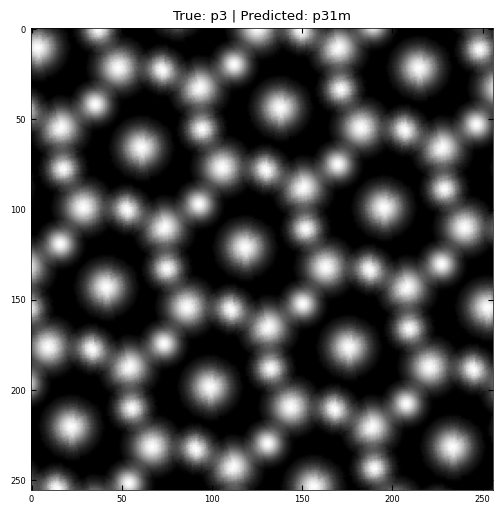

Top 5 incorrect predictions:
p31m: 99.96%
p3: 0.03%
p1: 0.02%
p6: 0.00%
p4g: 0.00%


In [ ]:
most_confused_class_1, most_confused_class_2 = most_confused_pairs(cm, atom_ds)

# Step 4: Investigate misclassified examples for these classes
batch = next(iter(atom_dl))  # Get a batch of images
show_prediction_example(model, batch, most_confused_class_1, most_confused_class_2, valid_ds.classes, device, k=5)